In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import os

############################################################
# Step 1: Load the Data and Model
############################################################

# File paths
X_test_path = r'data\combined\X_test.csv'
y_test_path = r'data\combined\y_test.csv'
model_path = r'data\models\route_predictor_model.pkl'
player_play_path = r'data\combined\final_player_play_data.csv'
players_path = r'data\raw\players.csv'

# Load test data and model
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)
player_play_df = pd.read_csv(player_play_path)
players_df = pd.read_csv(players_path)

# Load the trained XGBoost model
xgb_model = joblib.load(model_path)

# Predict probabilities for each play
print("Predicting probabilities for each route on the test set...")
route_probs = xgb_model.predict_proba(X_test)

############################################################
# Step 2: Calculate Route Deceptiveness Score (RDS)
############################################################

# Add route probabilities and actual routes to a DataFrame
results_df = X_test.copy()
results_df['actual_route'] = y_test
results_df['predicted_route'] = np.argmax(route_probs, axis=1)
results_df['max_prob'] = np.max(route_probs, axis=1)
results_df['actual_prob'] = [route_probs[i, y_test.iloc[i, 0]] for i in range(len(y_test))]

# Calculate deceptiveness score for each play
results_df['deceptiveness_score'] = 1 - (results_df['actual_prob'] / results_df['max_prob'])

############################################################
# Step 3: Aggregate Deceptiveness Scores by Wide Receiver
############################################################

# Merge player information into results to identify which player was involved in each play
results_df['gameId'] = player_play_df['gameId']
results_df['playId'] = player_play_df['playId']
results_df['nflId'] = player_play_df['nflId']

# Merge player position data to identify only wide receivers
players_df['nflId'] = players_df['nflId'].astype(float)
results_df = results_df.merge(players_df[['nflId', 'displayName', 'position']], on='nflId', how='left')

# Filter to only include wide receivers
wr_results_df = results_df[results_df['position'] == 'WR']

# Calculate average Route Deceptiveness Score (RDS) for each wide receiver
wr_rds = wr_results_df.groupby(['nflId', 'displayName'])['deceptiveness_score'].mean().reset_index()
wr_rds.rename(columns={'deceptiveness_score': 'route_deceptiveness_score'}, inplace=True)

# Rank wide receivers by their Route Deceptiveness Score
wr_rds['rank'] = wr_rds['route_deceptiveness_score'].rank(ascending=False)

# Sort by RDS for display
wr_rds = wr_rds.sort_values(by='route_deceptiveness_score', ascending=False)

# Display the top 10 most deceptive wide receivers
print("\nTop 10 Most Deceptive Wide Receivers by Route Deceptiveness Score (RDS):")
print(wr_rds.head(10))

############################################################
# Step 4: Save the RDS results to a CSV (Including nflId)
############################################################

# Save RDS for each WR to a CSV file, now including nflId
output_path = r'data\combined\route_deceptiveness_scores.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
wr_rds.to_csv(output_path, index=False)
print(f"Route Deceptiveness Scores saved to {output_path}")


Predicting probabilities for each route on the test set...

Top 10 Most Deceptive Wide Receivers by Route Deceptiveness Score (RDS):
       nflId       displayName  route_deceptiveness_score  rank
209  54850.0     Kyric McGowan                   0.508833   1.0
170  53538.0   Dez Fitzpatrick                   0.500000   2.0
18   41500.0      Willie Snead                   0.437544   3.0
9    40024.0      Keenan Allen                   0.384976   4.0
27   42437.0     Ty Montgomery                   0.375511   5.0
120  48988.0  Gunner Olszewski                   0.370701   6.0
51   44908.0    Kenny Golladay                   0.369035   7.0
40   43495.0       Mike Thomas                   0.367018   8.0
115  48576.0       Jason Moore                   0.366171   9.0
145  52620.0     Dezmon Patmon                   0.360339  10.0
Route Deceptiveness Scores saved to data\combined\route_deceptiveness_scores.csv


In [5]:
import pandas as pd

# File paths
player_play_path = r'data\combined\final_player_play_data.csv'
route_deceptiveness_scores_path = r'data\combined\route_deceptiveness_scores.csv'

# Load player play data and route deceptiveness scores
player_play_df = pd.read_csv(player_play_path)
route_deceptiveness_scores_df = pd.read_csv(route_deceptiveness_scores_path)

# Count the number of routes run for each wide receiver
route_counts = player_play_df.groupby('nflId')['routeRan'].count().reset_index()
route_counts.rename(columns={'routeRan': 'route_count'}, inplace=True)

# Merge the route counts with the route deceptiveness scores
combined_df = route_deceptiveness_scores_df.merge(route_counts, on='nflId', how='left')

# Filter wide receivers who have more than 100 routes run
filtered_df = combined_df[combined_df['route_count'] > 100]

# Sort by route deceptiveness score and select the top 10
top_10_deceptive_wrs = filtered_df.sort_values(by='route_deceptiveness_score', ascending=False).head(10)

# Display the top 10 most deceptive wide receivers with more than 100 routes run
print("\nTop 10 Most Deceptive Wide Receivers with More Than 100 Routes Run:")
print(top_10_deceptive_wrs)



Top 10 Most Deceptive Wide Receivers with More Than 100 Routes Run:
      nflId       displayName  route_deceptiveness_score  rank  route_count
11  52500.0    Devin Duvernay                   0.341668  12.0          184
18  47954.0    Darius Slayton                   0.331973  19.0          106
20  52454.0       K.J. Hamler                   0.328276  21.0          140
22  47847.0        DK Metcalf                   0.326276  23.0          218
25  46150.0    Michael Gallup                   0.324164  26.0          114
29  52430.0  Justin Jefferson                   0.319648  30.0          302
31  39989.0      Robert Woods                   0.317917  32.0          148
34  44003.0    Marcus Johnson                   0.315577  35.0          109
35  54476.0       Chris Olave                   0.315339  36.0          246
36  48489.0       David Sills                   0.315275  37.0          102


In [52]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# File paths
final_player_play_path = r"C:\Users\RaymondCarpenter\Documents\GitHub\bigdatabowl2025\data\combined\final_player_play_data.csv"
player_play_path = r"C:\Users\RaymondCarpenter\Documents\GitHub\route_deceptiveness_score\data\raw\player_play.csv"
route_deceptiveness_path = r"C:\Users\RaymondCarpenter\Documents\GitHub\bigdatabowl2025\data\combined\route_deceptiveness_scores.csv"

# Load datasets
df_final_player_play = pd.read_csv(final_player_play_path)
df_player_play = pd.read_csv(player_play_path)
df_route_deceptiveness = pd.read_csv(route_deceptiveness_path)

# Merge the two datasets to bring in the 'teamAbbr' column
df_final_player_play = df_final_player_play.merge(
    df_player_play[['gameId', 'playId', 'nflId', 'teamAbbr']],
    on=['gameId', 'playId', 'nflId'],
    how='left'
)

# Ensure relevant columns have correct types
df_final_player_play['nflId'] = df_final_player_play['nflId'].astype(float)

# Aggregate total routes by player and get the teamAbbr
df_summary = df_final_player_play.groupby('nflId').agg(
    total_routes=('routeRan', 'count'),
    teamAbbr=('teamAbbr', 'first')
).reset_index()

# Merge with route_deceptiveness to include RDS and displayName
df_merged = pd.merge(
    df_summary,
    df_route_deceptiveness[['nflId', 'displayName', 'route_deceptiveness_score']],
    on='nflId',
    how='left'
)

# Filter players with more than 150 routes
filtered_players = df_merged[(df_merged['total_routes'] > 150) & (df_merged['displayName'].notnull())]

# Sort for top and bottom players
top_10_filtered = filtered_players.sort_values('route_deceptiveness_score', ascending=False).head(10)
bottom_10_filtered = filtered_players.sort_values('route_deceptiveness_score', ascending=False).tail(10)

# Select relevant columns for display
columns_to_display = ['displayName', 'teamAbbr', 'route_deceptiveness_score', 'total_routes']

# Rename columns for clarity
top_10_filtered_display = top_10_filtered[columns_to_display].rename(
    columns={
        'displayName': 'Name',
        'teamAbbr': 'Team',
        'route_deceptiveness_score': 'RDS',
        'total_routes': 'Total Routes Ran'
    }
)

bottom_10_filtered_display = bottom_10_filtered[columns_to_display].rename(
    columns={
        'displayName': 'Name',
        'teamAbbr': 'Team',
        'route_deceptiveness_score': 'RDS',
        'total_routes': 'Total Routes Ran'
    }
)

# Visualization helper functions
def value_to_cell_color(value, ranges):
    if (ranges[1] - ranges[0]) == 0:
        norm_value = 0.5
    else:
        norm_value = (value - ranges[0]) / (ranges[1] - ranges[0])
    cmap = plt.get_cmap('summer_r')
    norm = mcolors.Normalize(vmin=0, vmax=1)
    scalar_mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
    rgba_color = scalar_mappable.to_rgba(norm_value)
    hex_color = mcolors.to_hex(rgba_color)
    return hex_color

def value_to_text_color(value, ranges):
    if (ranges[1] - ranges[0]) == 0:
        norm_value = 0.5
    else:
        norm_value = (value - ranges[0]) / (ranges[1] - ranges[0])
    return "black" if norm_value < 0.5 else "white"

def make_pretty(styler, caption):
    styler.set_caption(caption).set_table_styles(
        [{'selector': 'caption', 'props': 'caption-side: bottom; font-size:1.25em;'}],
        overwrite=False
    )
    styler.format(precision=3)
    return styler

def color_rates(styler, df):
    v_routes = [df["Total Routes Ran"].min(), df["Total Routes Ran"].max()]
    v_rds = [df["RDS"].min(), df["RDS"].max()]
    styler.map(
        lambda v: f'background: {value_to_cell_color(v, v_routes)}; color: {value_to_text_color(v, v_routes)}',
        subset=["Total Routes Ran"]
    )
    styler.map(
        lambda v: f'background: {value_to_cell_color(v, v_rds)}; color: {value_to_text_color(v, v_rds)}',
        subset=["RDS"]
    )
    return styler

# Apply styling for top and bottom 10
styled_top_10 = top_10_filtered_display.style.pipe(
    make_pretty, caption="Top 10 Receivers by RDS (Minimum 150 Routes)"
)
styled_top_10 = color_rates(styler=styled_top_10, df=top_10_filtered_display)

styled_bottom_10 = bottom_10_filtered_display.style.pipe(
    make_pretty, caption="Bottom 10 Receivers by RDS (Minimum 150 Routes)"
)
styled_bottom_10 = color_rates(styler=styled_bottom_10, df=bottom_10_filtered_display)

# Convert to HTML and save (optional)
html_table_top_10 = styled_top_10.to_html()
html_table_bottom_10 = styled_bottom_10.to_html()

with open("top_10_filtered_table.html", "w") as f:
    f.write(html_table_top_10)
with open("bottom_10_filtered_table.html", "w") as f:
    f.write(html_table_bottom_10)

# Display tables in the notebook
display(styled_top_10)
display(styled_bottom_10)


,Name,Team,RDS,Total Routes Ran
293,Devin Duvernay,BAL,0.342,184
216,DK Metcalf,SEA,0.326,218
271,Justin Jefferson,MIN,0.320,302
407,Chris Olave,NO,0.315,246
30,Allen Robinson,LA,0.303,279
417,Alec Pierce,IND,0.301,228
355,Josh Palmer,LAC,0.301,251
306,K.J. Osborn,MIN,0.300,245
307,Donovan Peoples-Jones,CLE,0.298,223
49,Tyler Lockett,SEA,0.296,229


,Name,Team,RDS,Total Routes Ran
129,Noah Brown,DAL,0.238,183
406,Garrett Wilson,NYJ,0.237,254
27,Brandin Cooks,HOU,0.235,214
206,Marquise Brown,ARI,0.235,238
120,Mack Hollins,LV,0.234,279
98,Corey Davis,NYJ,0.231,193
149,D.J. Moore,CAR,0.228,255
57,Stefon Diggs,BUF,0.227,242
336,Marquez Callaway,NO,0.225,165
75,Tyler Boyd,CIN,0.216,309


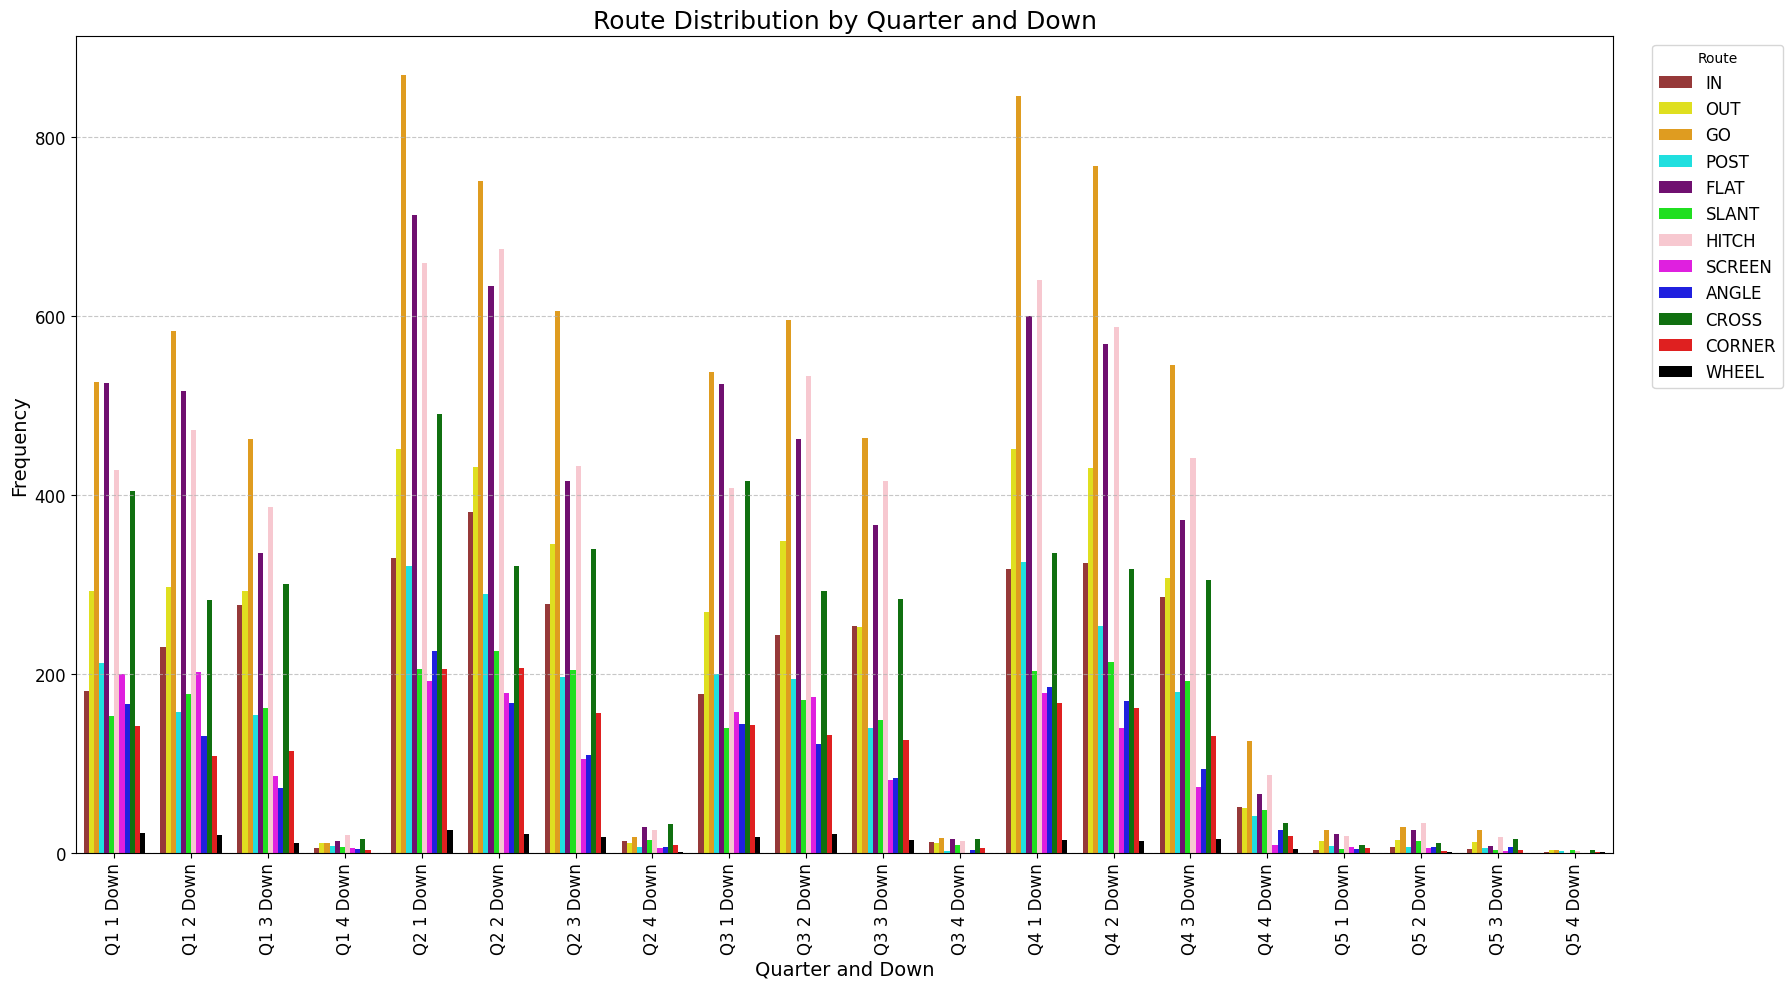

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the player play data
player_play_df = pd.read_csv(r'data\combined\final_player_play_data.csv')

# Load the plays data
plays_df = pd.read_csv(r'data\raw\plays.csv')

# Merge player play data with plays data to get down, distance, and quarter
merged_df = player_play_df.merge(
    plays_df[['gameId', 'playId', 'down', 'yardsToGo', 'quarter']],
    on=['gameId', 'playId'],
    how='left'
)

# Create a new column combining quarter and down
merged_df['quarter_down'] = 'Q' + merged_df['quarter'].astype(str) + ' ' + merged_df['down'].astype(str) + ' Down'

# Filter out rows where routeRan is NaN (if necessary)
merged_df = merged_df.dropna(subset=['routeRan'])

# Define route colors
route_colors = {
    'ANGLE': 'blue', 'CORNER': 'red', 'CROSS': 'green', 'FLAT': 'purple', 
    'GO': 'orange', 'HITCH': 'pink', 'IN': 'brown', 'OUT': 'yellow',
    'POST': 'cyan', 'SCREEN': 'magenta', 'SLANT': 'lime', 'WHEEL': 'black'
}

# Plot
plt.figure(figsize=(18, 10))
sns.countplot(
    x='quarter_down', 
    hue='routeRan', 
    data=merged_df, 
    palette=route_colors,
    order=sorted(merged_df['quarter_down'].unique())  # Ensure consistent order
)
plt.title('Route Distribution by Quarter and Down', fontsize=18)
plt.xlabel('Quarter and Down', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for easier comparison
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Route', fontsize=12)
plt.tight_layout()
plt.show()